Hypothesis 1:

Feed in model 1 row with race info and 8 motorbike to predict probability each motorbike to win (model output with 'softmax' activation) and sort motorbikes order by probability to win.

Hypothesis 2:

Build 8 models for each motorbike number with softmax output activation (8 classes).
Each model predict place in the race for it's motorbike number.

In this case Y_train label will be the place in the race for this motorbike.

Total 8 x_train datasets, 8 y_train datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D,MaxPooling1D, Activation, Reshape, Embedding, SpatialDropout1D
import keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, CategoricalCrossentropy 
from keras.utils import plot_model
from keras.models import load_model
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
data_to_predict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/autorace/predict.csv')

# Get columns from dataset to predict
all_columns = data_to_predict.columns.to_list()
# Columns to drop from result dataset
inverse_results_columns = all_columns.copy()
inverse_results_columns.remove('raceinfo_id')
inverse_results_columns.remove('motorbikeno')
all_columns.append('y')


In [4]:
data_initial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/autorace/race_2008_2015.csv')
data_initial.head()

,raceinfo_id,hold_date,place_num,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,all_refund,all_race_order,xorder,racetime,all_racetime,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,...,p2_Other_180_All_All_raceaccident,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time
0,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,1,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,3,3.409,106.7017,30,3.32,1,0.088,3.408,3.438,59,6,A-37,S-38,81.724,0,3,3,3,30.0,60.0,3.34,3.428,3.410,21,...,0.0,3.397,3.34,0.18,3.430,3.460,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438
1,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,2,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,2,3.403,106.5139,30,3.29,1,0.099,3.389,3.419,32,26,S-52,S-50,89.141,0,1,2,6,10.0,30.0,3.33,3.429,3.383,24,...,0.0,3.395,3.30,0.17,3.322,3.352,3.45,3.498,8,0,0,2,2,0,0.0,0.0,25.0,0.0,3.395,3.30,0.18,3.338,3.368,3.43,3.489,2,0,0,1,1,0,0.0,0.0,50.0,0.0,3.422,3.38,0.14,3.349,3.379
2,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,3,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,6,3.452,107.7024,20,3.36,1,0.083,3.443,3.463,35,24,A-90,A-72,75.002,1,0,0,8,10.0,10.0,3.36,3.443,3.428,13,...,50.0,3.447,3.43,0.20,3.377,3.397,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463
3,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,4,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,5,3.436,107.2032,20,3.35,1,0.071,3.421,3.441,33,26,A-18,A-87,84.382,1,0,2,7,10.0,30.0,3.35,3.421,3.397,24,...,0.0,3.395,3.34,0.17,3.402,3.422,3.45,3.492,4,0,0,1,1,0,0.0,0.0,25.0,0.0,3.429,3.37,0.18,3.392,3.412,3.52,3.540,2,0,0,0,1,0,0.0,0.0,0.0,0.0,3.449,3.41,0.12,3.370,3.390
4,7321,2008/1/2 0:00,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,5,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,8,3.502,108.9122,10,3.36,1,0.084,3.444,3.454,29,29,A-172,B-1,64.817,1,1,1,6,22.2,33.3,3.38,3.464,3.441,15,...,0.0,3.436,3.37,0.18,3.341,3.351,3.39,3.436,1,0,0,0,1,0,0.0,0.0,0.0,0.0,3.436,3.39,0.16,3.406,3.416,3.38,3.464,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.444,3.454


In [5]:
race_results = data_initial.copy()
# Keep only columns with race id and results
race_results.drop(inverse_results_columns, axis=1, inplace=True)
race_results.head()

,raceinfo_id,hold_date,motorbikeno,all_refund,all_race_order,xorder,racetime,all_racetime
0,7321,2008/1/2 0:00,1,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,3,3.409,106.7017
1,7321,2008/1/2 0:00,2,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,2,3.403,106.5139
2,7321,2008/1/2 0:00,3,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,6,3.452,107.7024
3,7321,2008/1/2 0:00,4,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,5,3.436,107.2032
4,7321,2008/1/2 0:00,5,900:110_100_100:0:740:250_220_120:2310:320:3940,7_2_1_8_4_3_6_5,8,3.502,108.9122


In [31]:
# Add win_motorbike column to dataset
def get_win_motorbike(all_race_order):
  return all_race_order.split('_')[0]

data = data_initial.copy()
data.loc[data['xorder']==9, 'xorder'] = 8
data['y'] = data['xorder']

# Keep only columns without result (as in dataset to predict)
data = data[all_columns]
data.head(3)


,raceinfo_id,place_num,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,...,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time,y
0,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,1,30,3.32,1,0.088,3.408,3.438,59,6,A-37,S-38,81.724,0,3,3,3,30.0,60.0,3.34,3.428,3.410,21,1,0,3.410,kawaguchi,1,0.14,...,3.397,3.34,0.18,3.430,3.460,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,3.408,3.438,3.34,3.428,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.408,3.438,3
1,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,2,30,3.29,1,0.099,3.389,3.419,32,26,S-52,S-50,89.141,0,1,2,6,10.0,30.0,3.33,3.429,3.383,24,2,0,3.383,kawaguchi,1,0.17,...,3.395,3.30,0.17,3.322,3.352,3.45,3.498,8,0,0,2,2,0,0.0,0.0,25.0,0.0,3.395,3.3,0.18,3.338,3.368,3.43,3.489,2,0,0,1,1,0,0.0,0.0,50.0,0.0,3.422,3.38,0.14,3.349,3.379,2
2,7321,2,kawaguchi,1,3100,good,1,sunny,4,19.0,9,42,3,20,3.36,1,0.083,3.443,3.463,35,24,A-90,A-72,75.002,1,0,0,8,10.0,10.0,3.36,3.443,3.428,13,1,0,3.428,kawaguchi,1,0.18,...,3.447,3.43,0.20,3.377,3.397,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.0,0.00,3.443,3.463,3.36,3.443,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,3.443,3.463,6


In [32]:
columns_to_encode = ['situation',
 'weather_name3',
 'last90_highplace',
 'place_code',
 'distance',
 'handicap',
 'last10_num1th',
 'last10_num2th',
 'last10_num3th',
 'last10_numother',
 'last90_numwin',
 'last90_numwinwin',
 'last90_highplace_home',
 'last180_rate1_numall',
 'last180_rate1_num2th',
 'last5_times1_home',
 'last5_times1_race',
 'last5_times1_handi',
 'last5_times1_order',
 'last5_times2_home',
 'last5_times2_race',
 'last5_times2_handi',
 'last5_times2_order',
 'last5_times3_home',
 'last5_times3_race',
 'last5_times3_handi',
 'last5_times3_order',
 'last5_times4_home',
 'last5_times4_race',
 'last5_times4_handi',
 'last5_times4_order',
 'last5_times5_home',
 'last5_times5_race',
 'last5_times5_handi',
 'last5_times5_order',
 'this_numwinwin',
 'this_numwin',
 'p2_0_180_All_All_numwinwin',
 'p2_0_90_All_Here_numwinwin',
 'p2_0_90_10_All_numwinwin',
 'p2_1_180_All_All_numwinwin',
 'p2_1_90_All_All_numwinwin',
 'p2_All_180_All_All_numwinwin',
 'p2_All_90_All_All_numwinwin',
 'p2_All_90_All_Here_numwinwin',
 'p2_All_90_10_All_numwinwin',
 'p2_All_90_10_Here_numwinwin',
 'raceno',
 'raceclass_code',
 'popular',
 'home']

In [33]:
columns_to_scale = ['roadtemp',
 'temp',
 'humid',
 'traialtime',
 'hensa',
 'shisou_hensa',
 'soutei_time',
 'age',
 'graduation',
 'rank_now',
 'rank_last',
 'point',
 'last10_rate2th',
 'last10_rate3th',
 'last10_trialave',
 'last10_raceave',
 'last10_racehigh',
 'last90_numall',
 'last90_hightime',
 'last90_stave',
 'last180_rate0_rate2th',
 'last180_rate0_numall',
 'last180_rate0_num2th',
 'last180_rate1_rate2th',
 'last5_times1_racetime',
 'last5_times1_trialtime',
 'last5_times1_sttime',
 'last5_times2_racetime',
 'last5_times2_trialtime',
 'last5_times2_sttime',
 'last5_times3_racetime',
 'last5_times3_trialtime',
 'last5_times3_sttime',
 'last5_times4_racetime',
 'last5_times4_trialtime',
 'last5_times4_sttime',
 'last5_times5_racetime',
 'last5_times5_trialtime',
 'last5_times5_sttime',
 'life_numwinwin',
 'life_numwin',
 'p2_0_180_All_All_trialavg',
 'p2_0_180_All_All_raceave',
 'p2_0_180_All_All_numall',
 'p2_0_180_All_All_num1th',
 'p2_0_180_All_All_num2th',
 'p2_0_180_All_All_num3th',
 'p2_0_180_All_All_numwin',
 'p2_0_180_All_All_rate1th',
 'p2_0_180_All_All_rate2th',
 'p2_0_180_All_All_rate3th',
 'p2_0_180_All_All_raceaccident',
 'p2_0_180_All_All_racehigh',
 'p2_0_180_All_All_traialhigh',
 'p2_0_180_All_All_stave',
 'p2_0_180_All_All_shisou_hensa',
 'p2_0_180_All_All_soutei_time',
 'p2_0_90_All_All_trialavg',
 'p2_0_90_All_All_raceave',
 'p2_0_90_All_All_numall',
 'p2_0_90_All_All_num1th',
 'p2_0_90_All_All_num2th',
 'p2_0_90_All_All_num3th',
 'p2_0_90_All_All_numwin',
 'p2_0_90_All_All_numwinwin',
 'p2_0_90_All_All_rate1th',
 'p2_0_90_All_All_rate2th',
 'p2_0_90_All_All_rate3th',
 'p2_0_90_All_All_raceaccident',
 'p2_0_90_All_All_racehigh',
 'p2_0_90_All_All_traialhigh',
 'p2_0_90_All_All_stave',
 'p2_0_90_All_All_shisou_hensa',
 'p2_0_90_All_All_soutei_time',
 'p2_0_90_All_Here_trialavg',
 'p2_0_90_All_Here_raceave',
 'p2_0_90_All_Here_numall',
 'p2_0_90_All_Here_num1th',
 'p2_0_90_All_Here_num2th',
 'p2_0_90_All_Here_num3th',
 'p2_0_90_All_Here_numwin',
 'p2_0_90_All_Here_rate1th',
 'p2_0_90_All_Here_rate2th',
 'p2_0_90_All_Here_rate3th',
 'p2_0_90_All_Here_raceaccident',
 'p2_0_90_All_Here_racehigh',
 'p2_0_90_All_Here_traialhigh',
 'p2_0_90_All_Here_stave',
 'p2_0_90_All_Here_shisou_hensa',
 'p2_0_90_All_Here_soutei_time',
 'p2_0_90_10_All_trialavg',
 'p2_0_90_10_All_raceave',
 'p2_0_90_10_All_numall',
 'p2_0_90_10_All_num1th',
 'p2_0_90_10_All_num2th',
 'p2_0_90_10_All_num3th',
 'p2_0_90_10_All_numwin',
 'p2_0_90_10_All_rate1th',
 'p2_0_90_10_All_rate2th',
 'p2_0_90_10_All_rate3th',
 'p2_0_90_10_All_raceaccident',
 'p2_0_90_10_All_racehigh',
 'p2_0_90_10_All_traialhigh',
 'p2_0_90_10_All_stave',
 'p2_0_90_10_All_shisou_hensa',
 'p2_0_90_10_All_soutei_time',
 'p2_1_180_All_All_trialavg',
 'p2_1_180_All_All_raceave',
 'p2_1_180_All_All_numall',
 'p2_1_180_All_All_num1th',
 'p2_1_180_All_All_num2th',
 'p2_1_180_All_All_num3th',
 'p2_1_180_All_All_numwin',
 'p2_1_180_All_All_rate1th',
 'p2_1_180_All_All_rate2th',
 'p2_1_180_All_All_rate3th',
 'p2_1_180_All_All_raceaccident',
 'p2_1_180_All_All_racehigh',
 'p2_1_180_All_All_traialhigh',
 'p2_1_180_All_All_stave',
 'p2_1_180_All_All_shisou_hensa',
 'p2_1_180_All_All_soutei_time',
 'p2_1_90_All_All_trialavg',
 'p2_1_90_All_All_raceave',
 'p2_1_90_All_All_numall',
 'p2_1_90_All_All_num1th',
 'p2_1_90_All_All_num2th',
 'p2_1_90_All_All_num3th',
 'p2_1_90_All_All_numwin',
 'p2_1_90_All_All_rate1th',
 'p2_1_90_All_All_rate2th',
 'p2_1_90_All_All_rate3th',
 'p2_1_90_All_All_raceaccident',
 'p2_1_90_All_All_racehigh',
 'p2_1_90_All_All_traialhigh',
 'p2_1_90_All_All_stave',
 'p2_1_90_All_All_shisou_hensa',
 'p2_1_90_All_All_soutei_time',
 'p2_1_90_All_Here_trialavg',
 'p2_1_90_All_Here_raceave',
 'p2_1_90_All_Here_numall',
 'p2_1_90_All_Here_num1th',
 'p2_1_90_All_Here_num2th',
 'p2_1_90_All_Here_num3th',
 'p2_1_90_All_Here_numwin',
 'p2_1_90_All_Here_numwinwin',
 'p2_1_90_All_Here_rate1th',
 'p2_1_90_All_Here_rate2th',
 'p2_1_90_All_Here_rate3th',
 'p2_1_90_All_Here_raceaccident',
 'p2_1_90_All_Here_racehigh',
 'p2_1_90_All_Here_traialhigh',
 'p2_1_90_All_Here_stave',
 'p2_1_90_All_Here_shisou_hensa',
 'p2_1_90_All_Here_soutei_time',
 'p2_All_180_All_All_trialavg',
 'p2_All_180_All_All_raceave',
 'p2_All_180_All_All_numall',
 'p2_All_180_All_All_num1th',
 'p2_All_180_All_All_num2th',
 'p2_All_180_All_All_num3th',
 'p2_All_180_All_All_numwin',
 'p2_All_180_All_All_rate1th',
 'p2_All_180_All_All_rate2th',
 'p2_All_180_All_All_rate3th',
 'p2_All_180_All_All_raceaccident',
 'p2_All_180_All_All_racehigh',
 'p2_All_180_All_All_traialhigh',
 'p2_All_180_All_All_stave',
 'p2_All_180_All_All_shisou_hensa',
 'p2_All_180_All_All_soutei_time',
 'p2_All_90_All_All_trialavg',
 'p2_All_90_All_All_raceave',
 'p2_All_90_All_All_numall',
 'p2_All_90_All_All_num1th',
 'p2_All_90_All_All_num2th',
 'p2_All_90_All_All_num3th',
 'p2_All_90_All_All_numwin',
 'p2_All_90_All_All_rate1th',
 'p2_All_90_All_All_rate2th',
 'p2_All_90_All_All_rate3th',
 'p2_All_90_All_All_raceaccident',
 'p2_All_90_All_All_racehigh',
 'p2_All_90_All_All_traialhigh',
 'p2_All_90_All_All_stave',
 'p2_All_90_All_All_shisou_hensa',
 'p2_All_90_All_All_soutei_time',
 'p2_All_90_All_Here_trialavg',
 'p2_All_90_All_Here_raceave',
 'p2_All_90_All_Here_numall',
 'p2_All_90_All_Here_num1th',
 'p2_All_90_All_Here_num2th',
 'p2_All_90_All_Here_num3th',
 'p2_All_90_All_Here_numwin',
 'p2_All_90_All_Here_rate1th',
 'p2_All_90_All_Here_rate2th',
 'p2_All_90_All_Here_rate3th',
 'p2_All_90_All_Here_raceaccident',
 'p2_All_90_All_Here_racehigh',
 'p2_All_90_All_Here_traialhigh',
 'p2_All_90_All_Here_stave',
 'p2_All_90_All_Here_shisou_hensa',
 'p2_All_90_All_Here_soutei_time',
 'p2_All_90_10_All_trialavg',
 'p2_All_90_10_All_raceave',
 'p2_All_90_10_All_numall',
 'p2_All_90_10_All_num1th',
 'p2_All_90_10_All_num2th',
 'p2_All_90_10_All_num3th',
 'p2_All_90_10_All_numwin',
 'p2_All_90_10_All_rate1th',
 'p2_All_90_10_All_rate2th',
 'p2_All_90_10_All_rate3th',
 'p2_All_90_10_All_raceaccident',
 'p2_All_90_10_All_racehigh',
 'p2_All_90_10_All_traialhigh',
 'p2_All_90_10_All_stave',
 'p2_All_90_10_All_shisou_hensa',
 'p2_All_90_10_All_soutei_time',
 'p2_All_90_10_Here_trialavg',
 'p2_All_90_10_Here_raceave',
 'p2_All_90_10_Here_numall',
 'p2_All_90_10_Here_num1th',
 'p2_All_90_10_Here_num2th',
 'p2_All_90_10_Here_num3th',
 'p2_All_90_10_Here_numwin',
 'p2_All_90_10_Here_rate1th',
 'p2_All_90_10_Here_rate2th',
 'p2_All_90_10_Here_rate3th',
 'p2_All_90_10_Here_raceaccident',
 'p2_All_90_10_Here_racehigh',
 'p2_All_90_10_Here_traialhigh',
 'p2_All_90_10_Here_stave',
 'p2_All_90_10_Here_shisou_hensa',
 'p2_All_90_10_Here_soutei_time',
 'p2_All_Life_All_All_trialavg',
 'p2_All_Life_All_All_raceave',
 'p2_All_Life_All_All_numall',
 'p2_All_Life_All_All_num1th',
 'p2_All_Life_All_All_num2th',
 'p2_All_Life_All_All_num3th',
 'p2_All_Life_All_All_numwin',
 'p2_All_Life_All_All_numwinwin',
 'p2_All_Life_All_All_rate1th',
 'p2_All_Life_All_All_rate2th',
 'p2_All_Life_All_All_rate3th',
 'p2_All_Life_All_All_raceaccident',
 'p2_All_Life_All_All_racehigh',
 'p2_All_Life_All_All_traialhigh',
 'p2_All_Life_All_All_stave',
 'p2_All_Life_All_All_shisou_hensa',
 'p2_All_Life_All_All_soutei_time',
 'p2_Other_180_All_All_trialavg',
 'p2_Other_180_All_All_raceave',
 'p2_Other_180_All_All_numall',
 'p2_Other_180_All_All_num1th',
 'p2_Other_180_All_All_num2th',
 'p2_Other_180_All_All_num3th',
 'p2_Other_180_All_All_numwin',
 'p2_Other_180_All_All_numwinwin',
 'p2_Other_180_All_All_rate1th',
 'p2_Other_180_All_All_rate2th',
 'p2_Other_180_All_All_rate3th',
 'p2_Other_180_All_All_raceaccident',
 'p2_Other_180_All_All_racehigh',
 'p2_Other_180_All_All_traialhigh',
 'p2_Other_180_All_All_stave',
 'p2_Other_180_All_All_shisou_hensa',
 'p2_Other_180_All_All_soutei_time',
 'p2_Other_90_All_All_trialavg',
 'p2_Other_90_All_All_raceave',
 'p2_Other_90_All_All_numall',
 'p2_Other_90_All_All_num1th',
 'p2_Other_90_All_All_num2th',
 'p2_Other_90_All_All_num3th',
 'p2_Other_90_All_All_numwin',
 'p2_Other_90_All_All_numwinwin',
 'p2_Other_90_All_All_rate1th',
 'p2_Other_90_All_All_rate2th',
 'p2_Other_90_All_All_rate3th',
 'p2_Other_90_All_All_raceaccident',
 'p2_Other_90_All_All_racehigh',
 'p2_Other_90_All_All_traialhigh',
 'p2_Other_90_All_All_stave',
 'p2_Other_90_All_All_shisou_hensa',
 'p2_Other_90_All_All_soutei_time',
 'p2_Other_90_All_Here_trialavg',
 'p2_Other_90_All_Here_raceave',
 'p2_Other_90_All_Here_numall',
 'p2_Other_90_All_Here_num1th',
 'p2_Other_90_All_Here_num2th',
 'p2_Other_90_All_Here_num3th',
 'p2_Other_90_All_Here_numwin',
 'p2_Other_90_All_Here_numwinwin',
 'p2_Other_90_All_Here_rate1th',
 'p2_Other_90_All_Here_rate2th',
 'p2_Other_90_All_Here_rate3th',
 'p2_Other_90_All_Here_raceaccident',
 'p2_Other_90_All_Here_racehigh',
 'p2_Other_90_All_Here_traialhigh',
 'p2_Other_90_All_Here_stave',
 'p2_Other_90_All_Here_shisou_hensa',
 'p2_Other_90_All_Here_soutei_time']

In [34]:
def replaceNaN(dataset) : 
  nullcolumns = []
  for c in dataset.columns :
      if dataset[c].isnull().any() : 
          nullcolumns.append(c)
          
  print('Before filling missing values' )
  print(nullcolumns)

  # fill average insted of missing value
  p2_columns = dataset.columns[dataset.columns.str.startswith('p2')]

  for column in p2_columns :
      dataset[column].fillna(dataset[column].mean(), inplace=True)

  # fill 0 instead of missing value
  for column in nullcolumns :
      dataset[column].fillna(0.0, inplace=True)
      
  # check NaN
  nullcolumns = []
  for c in dataset.columns :
      if dataset[c].isnull().any() : 
          nullcolumns.append(c)
          
  print('After filling missing values' )
  print(nullcolumns)

  return dataset

def calc_rank(x):
  if isinstance(x, float) :
      return 300;
  alpha = x[:1]
  num = int(x[2:])
  if alpha == 'S' :
      num = num
  elif alpha == 'A' :
      num += 100
  elif alpha == 'B' :
      num += 300
  elif alpha == 'C' :
      num += 400
  return num


def encode_to_labels(column, astype='str'):
  label_encoder = LabelEncoder()
  column = label_encoder.fit_transform(column.astype(astype))
  return column, label_encoder

def scale_column(column):
  scaler = MinMaxScaler((0,1))
  column = scaler.fit_transform(column.values.reshape(-1,1))
  return column

del data['place_num']
# Fill missing values
data = replaceNaN(data)
# Convert ranking to numbers
data['rank_now'] = data['rank_now'].apply(calc_rank)
data['rank_last'] = data['rank_last'].apply(calc_rank)

labels_dict = {}
for c in columns_to_encode:
  data[c], encoder = encode_to_labels(data[c])
  labels_dict.update([(c, len(encoder.classes_))])

for c in columns_to_scale:
  data[c] = scale_column(data[c])

Before filling missing values
['weather_name3', 'rank_last', 'last90_highplace', 'p2_0_180_All_All_stave', 'p2_0_90_All_All_stave', 'p2_1_90_All_Here_stave', 'p2_All_180_All_All_stave', 'p2_All_90_All_All_stave', 'p2_All_90_All_Here_stave', 'p2_All_90_10_All_stave', 'p2_All_90_10_Here_stave', 'p2_All_Life_All_All_stave', 'p2_Other_180_All_All_stave', 'p2_Other_90_All_All_stave', 'p2_Other_90_All_Here_stave']
After filling missing values
[]


In [35]:
data

,raceinfo_id,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,last180_rate0_rate2th,...,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time,y
0,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,1,5,0.706383,1,0.394619,0.714465,0.720755,0.732143,0.161290,0.268775,0.072266,0.539361,0,3,3,4,0.300,0.600,0.885942,0.907599,0.902833,0.437500,1,0,0.829079,5,1,0.341463,0.366,...,0.787071,0.8350,0.428571,0.724460,0.728491,0.858612,0.847257,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000,0.0,0.000000,0.000000,0.000000,0.721718,0.725645,0.841310,0.822260,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.728390,0.731732,3
1,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,2,5,0.700000,1,0.443946,0.710482,0.716771,0.250000,0.806452,0.100791,0.095703,0.588312,0,1,2,7,0.100,0.300,0.883289,0.907863,0.895684,0.500000,2,0,0.822514,5,1,0.414634,0.200,...,0.786608,0.8250,0.404762,0.702035,0.705882,0.886889,0.864558,0.001259,0.000000,0.000000,0.001873,0.005797,0.0,0.000,0.000,0.250,0.0,0.844107,0.848329,0.310345,0.707267,0.711074,0.863980,0.836891,0.000331,0.000000,0.0,0.000975,0.003077,0.0,0.0,0.0,0.5,0.0,0.848710,0.851385,0.233333,0.716502,0.719723,2
2,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,3,4,0.714894,1,0.372197,0.721803,0.725996,0.303571,0.741935,0.373518,0.333984,0.494997,1,0,0,9,0.100,0.100,0.891247,0.911570,0.907599,0.270833,1,0,0.833455,5,1,0.439024,0.400,...,0.798656,0.8575,0.476190,0.713455,0.715302,0.863753,0.850964,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000,0.0,0.000000,0.000000,0.000000,0.728943,0.730849,0.846348,0.825858,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.735442,0.736821,6
3,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,4,4,0.712766,1,0.318386,0.717191,0.721384,0.267857,0.806452,0.231225,0.363281,0.556903,1,0,2,8,0.100,0.300,0.888594,0.905745,0.899391,0.500000,2,0,0.825918,5,1,0.414634,0.356,...,0.786608,0.8350,0.404762,0.718646,0.720536,0.886889,0.863075,0.000629,0.000000,0.000000,0.000936,0.002899,0.0,0.000,0.000,0.250,0.0,0.852561,0.866324,0.310345,0.718415,0.720233,0.886650,0.849124,0.000331,0.000000,0.0,0.000000,0.003077,0.0,0.0,0.0,0.0,0.0,0.855407,0.858942,0.200000,0.720733,0.721962,5
4,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,5,1,0.714894,1,0.376682,0.722013,0.724109,0.196429,0.903226,0.535573,0.585938,0.427779,1,1,1,7,0.222,0.333,0.896552,0.917130,0.911041,0.312500,1,0,0.835400,1,0,0.365854,0.270,...,0.796108,0.8425,0.428571,0.7

In [36]:
# columns_to_encode = []
# columns_already_labeled = []
# columns_already_labeled.append('win_motorbike')
# # Encode_to_labels
# data['situation'], _ = encode_to_labels(data['situation'])
# data['weather_name3'], _ = encode_to_labels(data['weather_name3'])
# data['last90_highplace'], place_encoder = encode_to_labels(data['last90_highplace'])
# data['place_code'] = place_encoder.transform(data['place_code'])
# columns_to_encode.extend(['situation', 'weather_name3', 'last90_highplace', 'place_code'])
# columns_already_labeled.append(['situation', 'weather_name3', 'last90_highplace', 'place_code'])

# # Encode int columns to labels where max value - nbr unique value < 2
# columns_int_to_encode = []
# columns_mask_to_encode = [x for x in ((data[data.columns[data.dtypes=='int']].max() - data[data.columns[data.dtypes=='int']].nunique()) < 2)]
# for c  in (data[data.columns[data.dtypes=='int']].columns[columns_mask_to_encode]):
#   if c not in columns_already_labeled and c not in columns_to_encode:
#     data[c], _ = encode_to_labels(data[c], astype='int')
#     columns_int_to_encode.append(c)

# # Encode int columns to labels where max unique values <= 30
# columns_int_to_encode = []
# columns_mask_to_encode = [x for x in (data[data.columns[data.dtypes=='int']].nunique() <= 30 )]
# for c  in (data[data.columns[data.dtypes=='int']].columns[columns_mask_to_encode]):
#   if c not in columns_already_labeled and c not in columns_to_encode:
#     data[c], _ = encode_to_labels(data[c], astype='int')
#     columns_int_to_encode.append(c)

# columns_to_scale = []
# for c in data.columns:
#   if c not in columns_already_labeled and c not in columns_to_encode and c not in columns_int_to_encode:
#     columns_to_scale.append(c)

In [37]:
raceinfo_columns = ['place_num',
 'place_code',
 'raceno',
 'distance',
 'situation',
 'raceclass_code',
 'weather_name3',
 'popular',
 'roadtemp',
 'temp',
 'humid']

In [38]:
df_m1 = data[data['motorbikeno']==1]
df_m1

,raceinfo_id,place_code,raceno,distance,situation,raceclass_code,weather_name3,popular,roadtemp,temp,humid,motorbikeno,handicap,traialtime,home,hensa,shisou_hensa,soutei_time,age,graduation,rank_now,rank_last,point,last10_num1th,last10_num2th,last10_num3th,last10_numother,last10_rate2th,last10_rate3th,last10_trialave,last10_raceave,last10_racehigh,last90_numall,last90_numwin,last90_numwinwin,last90_hightime,last90_highplace,last90_highplace_home,last90_stave,last180_rate0_rate2th,...,p2_Other_180_All_All_racehigh,p2_Other_180_All_All_traialhigh,p2_Other_180_All_All_stave,p2_Other_180_All_All_shisou_hensa,p2_Other_180_All_All_soutei_time,p2_Other_90_All_All_trialavg,p2_Other_90_All_All_raceave,p2_Other_90_All_All_numall,p2_Other_90_All_All_num1th,p2_Other_90_All_All_num2th,p2_Other_90_All_All_num3th,p2_Other_90_All_All_numwin,p2_Other_90_All_All_numwinwin,p2_Other_90_All_All_rate1th,p2_Other_90_All_All_rate2th,p2_Other_90_All_All_rate3th,p2_Other_90_All_All_raceaccident,p2_Other_90_All_All_racehigh,p2_Other_90_All_All_traialhigh,p2_Other_90_All_All_stave,p2_Other_90_All_All_shisou_hensa,p2_Other_90_All_All_soutei_time,p2_Other_90_All_Here_trialavg,p2_Other_90_All_Here_raceave,p2_Other_90_All_Here_numall,p2_Other_90_All_Here_num1th,p2_Other_90_All_Here_num2th,p2_Other_90_All_Here_num3th,p2_Other_90_All_Here_numwin,p2_Other_90_All_Here_numwinwin,p2_Other_90_All_Here_rate1th,p2_Other_90_All_Here_rate2th,p2_Other_90_All_Here_rate3th,p2_Other_90_All_Here_raceaccident,p2_Other_90_All_Here_racehigh,p2_Other_90_All_Here_traialhigh,p2_Other_90_All_Here_stave,p2_Other_90_All_Here_shisou_hensa,p2_Other_90_All_Here_soutei_time,y
0,7321,4,0,0,0,1,6,3,0.263889,0.225,0.366667,1,5,0.706383,1,0.394619,0.714465,0.720755,0.732143,0.161290,0.268775,0.072266,0.539361,0,3,3,4,0.3,0.6,0.885942,0.907599,0.902833,0.437500,1,0,0.829079,5,1,0.341463,0.366,...,0.787071,0.8350,0.428571,0.724460,0.728491,0.858612,0.847257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.721718,0.725645,0.841310,0.822260,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.728390,0.731732,3
8,7322,4,4,0,0,1,6,0,0.277778,0.225,0.322222,1,5,0.712766,0,0.399103,0.720964,0.727254,0.267857,0.774194,0.312253,0.406250,0.516473,1,0,1,9,0.1,0.2,0.885942,0.907863,0.900185,0.520833,1,0,0.821298,6,0,0.585366,0.324,...,0.789620,0.8350,0.761905,0.716777,0.720745,0.886889,0.866535,0.000944,0.000000,0.000000,0.000936,0.000000,0.000000,0.000,0.000,0.167,0.167,0.856290,0.858612,0.620690,0.721305,0.725229,0.841310,0.822499,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.734636,0.738042,7
16,7323,4,5,0,0,1,6,3,0.291667,0.250,0.300000,1,5,0.700000,1,0.394619,0.708176,0.714465,0.125000,0.870968,0.209486,0.251953,0.565265,5,1,1,5,0.5,0.6,0.880637,0.902303,0.892507,0.562500,3,0,0.819596,5,1,0.317073,0.349,...,0.788925,0.8275,0.309524,0.702035,0.705882,0.894602,0.862086,0.000787,0.001253,0.000835,0.000000,0.002899,0.000000,0.400,0.600,0.600,0.200,0.846594,0.856041,0.172414,0.699009,0.702748,0.894207,0.846966,0.000331,0.000000,0.000862,0.000000,0.0,0.0,0.0,0.5,0.5,0.0,0.863591,0.881612,0.150000,0.700786,0.703847,2
24,7324,4,6,0,0,1,6,1,0.291667,0.250,0.288889,1,5,0.708511,0,0.376682,0.715723,0.722013,0.553571,0.451613,0.235178,0.099609,0.551181,0,2,1,8,0.2,0.3,0.891247,0.911835,0.905745,0.395833,0,0,0.825918,6,0,0.390244,0.120,...,0.787071,0.8325,0.380952,0.715739,0.719699,0.879177,0.852200,0.000629,0.000000,0.000835,0.000000,0.000000,0.000000,0.000,0.250,0.250,0.000,0.844605,0.856041,0.327586,0.711396,0.715237,0.846348,0.826097,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.729599,0.732953,4
32,7325,4,7,0,0,1,6,0,0.291667,0.275,0.288889,1,5,0.704255,1,0.408072,0.712998,0.719287,0.232143,0.774194,0.213439,0.558594,0.563879,3,1,2,6,0.3,0.5,0.883289,0.905745,0.897538,0.437500,1,0,0.824216,5,1,0.487805,0.175,...,0.793559,0.8425,0

In [39]:
def create_x_y(df_init):
  df = df_init.copy()
  x_train = []
  y_train = []
  del df['motorbikeno']
  del df['raceinfo_id']
  # add label
  y_train = df.y.values
  x_df = df.iloc[:,:-1]
  x_train = x_df.iloc[:,0].values.reshape(-1,1)
  x_train = to_categorical(x_train, num_classes=labels_dict[x_df.columns[0]])
  for c in x_df.columns[1:]:
    if c in columns_to_encode:
      x_train = np.hstack((x_train, to_categorical(x_df[c].values.reshape(-1,1), num_classes=labels_dict[c])))
    else:
      x_train = np.hstack((x_train, x_df[c].values.reshape(-1,1)))

  x_train = np.array(x_train)
  y_train = np.array(y_train).reshape(-1,1)-1
  y_train = to_categorical(y_train)
  return x_train, y_train

x_train, y_train = create_x_y(df_m1)

In [40]:
np.max(x_train[0])

1.0

In [41]:
# np.save('/content/drive/MyDrive/Colab Notebooks/autorace/x_train', x_train)
# np.save('/content/drive/MyDrive/Colab Notebooks/autorace/y_train', y_train)

In [42]:
# x_train = np.load('/content/drive/MyDrive/Colab Notebooks/autorace/x_train.npy')
# y_train = np.load('/content/drive/MyDrive/Colab Notebooks/autorace/y_train.npy')

In [43]:
# Split Train-Test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [44]:
# Split Train-Val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [45]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(24284, 924)
(24284, 8)
(6072, 924)
(6072, 8)
(7589, 924)
(7589, 8)


In [46]:
#callback
file_name = 'autorace_prediction_hyp2'
model_name = f'{file_name}'

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=90, min_lr=0.000001, verbose=1, mode="max" )
early_stop = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=120, verbose=1,
    mode='max', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Colab Notebooks/autorace/{model_name}.h5', monitor='val_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

Epoch 1/1000
2429/2429 [==============================] - 37s 15ms/step - loss: 2.0576 - accuracy: 0.1866 - val_loss: 1.9901 - val_accuracy: 0.2393

Epoch 00001: val_accuracy improved from -inf to 0.23930, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction_hyp2.h5
Epoch 2/1000
2429/2429 [==============================] - 35s 14ms/step - loss: 1.9973 - accuracy: 0.2277 - val_loss: 1.9637 - val_accuracy: 0.2513

Epoch 00002: val_accuracy improved from 0.23930 to 0.25132, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction_hyp2.h5
Epoch 3/1000
2429/2429 [==============================] - 34s 14ms/step - loss: 1.9771 - accuracy: 0.2369 - val_loss: 1.9523 - val_accuracy: 0.2523

Epoch 00003: val_accuracy improved from 0.25132 to 0.25231, saving model to /content/drive/MyDrive/Colab Notebooks/autorace/autorace_prediction_hyp2.h5
Epoch 4/1000
2429/2429 [==============================] - 35s 14ms/step - loss: 1.9530 - accuracy: 0

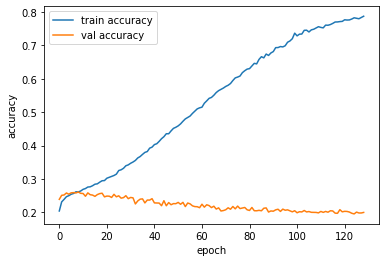

In [47]:
def create_model(x_train, y_train):
  model = Sequential()
  model.add(Dense(512, input_dim=(x_train.shape[1]), activation='relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  # model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(y_train.shape[1], activation='softmax'))

  return model

model = create_model(x_train, y_train)
model.compile(optimizer=Adam(lr=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    epochs=1000,
                    batch_size=10,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stop, checkpoint])


plt.plot(history.history['accuracy'], 
         label='train accuracy')
plt.plot(history.history['val_accuracy'], 
         label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()